In [1]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime
import time

In [2]:
from plot_functions import plot_results_by_month
from plot_functions import plot_results_with_uncertainty_by_month
from plot_functions import plot_residuals
from plot_functions import plot_train_vs_validation_loss
from plot_functions import plot_results_with_uncertainty_by_week
from helpers import day_ahead_forecast
from helpers import extract_residuals
from helpers import extract_all_residuals
from helpers import picp
from helpers import pinaw
from helpers import time_align_predictions

In [3]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

## Load pre-processed data

In [5]:
file_path = os.path.join(current_directory, 'data_augmented/X_train.npy')
X_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/y_train.npy')
y_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/timestamps_train.csv')
timestamps_train = pd.read_csv(file_path, parse_dates=True)
timestamps_train = timestamps_train.index

file_path = os.path.join(current_directory, 'data_augmented/X_test.npy')
X_test = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/y_test.npy')
y_test = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/timestamps_test.csv')
timestamps_test = pd.read_csv(file_path, index_col=0, parse_dates=True)
timestamps_test = timestamps_test.index

`X_train`, `X_test`, `y_train`, `y_test` are prepared in the file `data_preprocessing.ipynb`.

In [7]:
forecast_horizon = 24 # forecast horizon for predictions

In [8]:
# Train and test sets dimensions
print('Train set dimensions:')
print(X_train.shape) # (num_train_samples, seq_length, num_features)
print(y_train.shape) # (num_test_samples, forecast_horizon)
print('Test set dimensions:')
print(X_test.shape) # (num_train_samples, seq_length, num_features)
print(y_test.shape) # (num_test_samples, forecast_horizon)

Train set dimensions:
(17954, 168, 32)
(17954, 24)
Test set dimensions:
(745, 168, 32)
(745, 24)


## LSTM Model definition, training and evaluation 

In [10]:
# Determine device for computation 

import torch

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use the MPS device for Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Default to CPU if no GPU backend is available

print(f"Using device: {device}")

Using device: cpu


#### LSTM Model Architecture

This LSTM-based neural network is designed for multi-step forecasting tasks. Here's a breakdown of its architecture:

1. **Input Layer**:
   - Accepts sequences of shape `(batch_size, seq_length, input_size)` where:
     - `batch_size` is the number of samples in a batch.
     - `seq_length` is the length of the time-series sequences.
     - `input_size` is the number of features per time step.


2. **LSTM Layer**:
   - A stacked LSTM layer with:
     - `hidden_size` hidden units per layer.
     - `num_layers` stacked LSTM layers to capture complex temporal patterns.
     - Dropout applied between layers to reduce overfitting when `num_layers > 1`.


3. **Dropout Layer**:
   - A standalone dropout layer is applied to the last hidden state for regularization and Monte Carlo (MC) Dropout during inference.


4. **Fully Connected Layer**:
   - A linear layer maps the LSTM's final hidden state to the output of shape `(batch_size, output_size)`, where:
     - `output_size` is the number of forecasted time steps (e.g., 24 for 24-hour prediction).


5. **Monte Carlo Dropout**:
   - The `enable_mc_dropout` method allows dropout to remain active during inference for uncertainty estimation.

#### Workflow:
- The `forward` method processes input sequences through the LSTM and applies the dropout to the last hidden state before passing it through the fully connected layer.
- The `enable_mc_dropout` method is designed to switch dropout layers to "training mode" during inference, enabling stochastic predictions for Monte Carlo Dropout sampling.

This architecture balances the ability to learn temporal dependencies with mechanisms (like dropout) to prevent overfitting and quantify uncertainty in predictions.

In [12]:
# Define the LSTM Model

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # Output layer for multi-step forecasting

    def forward(self, x):
        # LSTM forward pass
        output, _ = self.lstm(x)
        # Take the last hidden state for forecasting
        last_hidden = output[:, -1, :]
        y = self.fc(last_hidden)
        return y
    
    def enable_mc_dropout(self):
        """Enable MC Dropout by setting all dropout layers to train mode."""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()
                
'''
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)  # Explicit dropout layer for MC Dropout
        self.fc = nn.Linear(hidden_size, output_size)  # Output layer for multi-step forecasting

    def forward(self, x):
        # LSTM forward pass
        output, _ = self.lstm(x)
        # Take the last hidden state for forecasting
        last_hidden = output[:, -1, :]
        last_hidden = self.dropout(last_hidden)  # Apply dropout here
        y = self.fc(last_hidden)
        return y
    
    def enable_mc_dropout(self):
        """Enable MC Dropout by setting all dropout layers to train mode."""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()
'''

'\nclass LSTMModel(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):\n        super(LSTMModel, self).__init__()\n        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)\n        self.dropout = nn.Dropout(dropout)  # Explicit dropout layer for MC Dropout\n        self.fc = nn.Linear(hidden_size, output_size)  # Output layer for multi-step forecasting\n\n    def forward(self, x):\n        # LSTM forward pass\n        output, _ = self.lstm(x)\n        # Take the last hidden state for forecasting\n        last_hidden = output[:, -1, :]\n        last_hidden = self.dropout(last_hidden)  # Apply dropout here\n        y = self.fc(last_hidden)\n        return y\n    \n    def enable_mc_dropout(self):\n        """Enable MC Dropout by setting all dropout layers to train mode."""\n        for module in self.modules():\n            if isinstance(module, nn.Dropout):\n                module.train()\n'

In [13]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### LSTM Model Training

1. **Model Initialization**:  
   - The LSTM model is initialized with the specified architecture, including input size, hidden size, number of layers, and dropout rate.  
   - The Adam optimizer is configured with a learning rate and L2 regularization (weight decay).  
   - The loss function used is Mean Squared Error (MSE).

2. **Mini-Batch Training**:  
   - Training data is divided into mini-batches for efficient computation.  
   - For each batch:  
     - Predictions are made using the model.  
     - Loss is computed using the MSE criterion.  
     - Gradients are backpropagated, and model parameters are updated using the optimizer.  
   - Training loss for the epoch is averaged and stored.

3. **Validation**:  
   - At the end of each epoch, the model is evaluated on the validation set.  
   - Validation loss is computed without updating the model weights (using `torch.no_grad()`).

4. **Early Stopping**:  
   - Monitors validation loss to decide when to stop training.  
   - If validation loss improves, the best model is saved.  
   - If no improvement is observed for a predefined number of epochs (patience limit), training halts early to prevent overfitting.
5. **Test Evaluation**:  
   - After training, the saved best model is loaded and evaluated on the test set.  
   - Final test loss is computed to assess the model’s generalization performance.

In [15]:
# Initialize the LSTM Model
input_size = X_train.shape[2]  # Number of features per time step
output_size = y_train.shape[1]  # Forecast horizon (24 hours)
hidden_size = 64  # Number of hidden units
num_layers = 2 # Number of LSTM layers
dropout_rate = 0.3

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)

# Optimizer
learning_rate = 1e-3
weight_decay = 1e-4  # L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

# Early stopping parameters
patience_limit = 5
best_val_loss = float("inf")
patience_counter = 0

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop with early stopping
num_epochs = 50  # Increased epochs to allow for early stopping
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Compute average training loss for the epoch
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)  # Save training loss

    end_time = time.time()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f} seconds")

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor.to(device))
        val_loss = criterion(val_predictions, y_test_tensor.to(device)).item()
        val_losses.append(val_loss)  # Save validation loss

    print(f"Validation Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'hidden_size': hidden_size,
            'output_size': output_size,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate,
            'X_train_tensor': X_train_tensor.cpu(),
            'X_test_tensor': X_test_tensor.cpu(),
            'y_train_tensor': y_train_tensor.cpu(),
            'y_test_tensor': y_test_tensor.cpu(),
            'batch_size': batch_size,
        }, "best_lstm_model_and_data.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break

Epoch 1, Loss: 0.3628, Time: 29.47 seconds
Validation Loss: 0.5366
Epoch 2, Loss: 0.2295, Time: 29.58 seconds
Validation Loss: 0.4724
Epoch 3, Loss: 0.2047, Time: 29.04 seconds
Validation Loss: 0.4674
Epoch 4, Loss: 0.1857, Time: 28.91 seconds
Validation Loss: 0.4382
Epoch 5, Loss: 0.1718, Time: 29.48 seconds
Validation Loss: 0.3626
Epoch 6, Loss: 0.1492, Time: 37.35 seconds
Validation Loss: 0.3364
Epoch 7, Loss: 0.1310, Time: 33.16 seconds
Validation Loss: 0.3092
Epoch 8, Loss: 0.1252, Time: 31.06 seconds
Validation Loss: 0.3410
Epoch 9, Loss: 0.1151, Time: 30.08 seconds
Validation Loss: 0.2797
Epoch 10, Loss: 0.1072, Time: 30.72 seconds
Validation Loss: 0.3398
Epoch 11, Loss: 0.1068, Time: 30.51 seconds
Validation Loss: 0.2951
Epoch 12, Loss: 0.0978, Time: 31.70 seconds
Validation Loss: 0.3240
Epoch 13, Loss: 0.0959, Time: 31.10 seconds
Validation Loss: 0.3067
Epoch 14, Loss: 0.0928, Time: 31.74 seconds
Validation Loss: 0.3183
Early stopping triggered.


### Evaluating Training vs. Validation Loss 

Training and validation loss are monitored during model training for understanding its learning behavior and generalization performance. In particular, it allows to:

1. **Detect Underfitting:** When both training and validation loss remain high, the model is too simple or hasn't learned enough from the data. This suggests a need for more training, features, or model complexity.

2. **Identify Overfitting:** A large gap between low training loss and high validation loss indicates the model is memorizing the training data and failing to generalize.

3. **Optimize Hyperparameters:** Observing the trend of losses helps tune parameters like learning rate, regularization strength, and dropout rate for better performance.

4. **Enable Early Stopping:** Tracking validation loss allows early stopping to prevent overfitting.

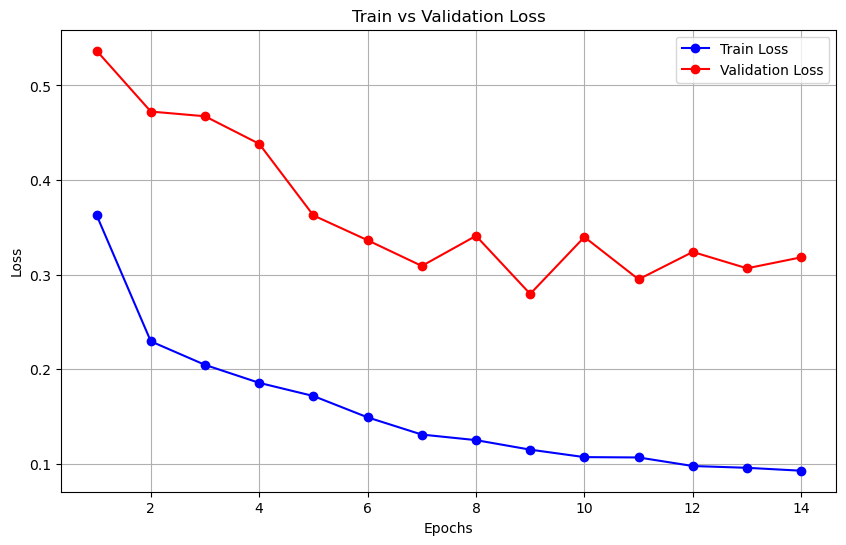

In [17]:
# Plot train and validation losses over epochs
file_path = os.path.join(current_directory, 'results/train_vs_validation_loss_LSTM.png')
plot_train_vs_validation_loss(range(1, len(train_losses) + 1),train_losses, val_losses, file_path)

### LSTM Model Evaluation

**Research Context**
The goal is to predict power consumption for the next 24 hours, aligned with real-world requirements for electricity market bidding. Predictions are made at 10 AM each day, as only data up until this point is available for making forecasts.

**Evaluation Strategy** 
The LSTM model generates predictions for 24-hour windows. These windows overlap, but only predictions made specifically at 10 AM are retained for evaluation. This aligns the evaluation process with the operational constraints of the electricity market, ensuring that the model simulates real-world decision-making.

**Model Evaluation**:  
   - After training, the best model (selected via early stopping) is used to generate predictions on the test set.  
   - Predictions made at 10 AM for the next 24 hours are extracted from the test set.  
   - These predictions are compared to the actual consumption values using the accuracy metrics RMSE, MAE, ME, MAPE. 
   - The predictions are plotted against actual consumption for interpretability and visual validation.  

In [20]:
# Test the model
checkpoint = torch.load("best_lstm_model_and_data.pth")
model.load_state_dict(checkpoint['model_state_dict'])  # Load the best model
model.eval()

# Evaluate on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor.to(device))
    test_loss = criterion(test_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.2797


In [21]:
# Save predicted and true target variable
y_pred = test_predictions.cpu().detach().numpy()  # Predictions, size: (num_test_samples, forecast_horizon)
y_true = y_test_tensor.cpu().numpy()  # Ground truth, size: (num_test_samples, forecast_horizon)

In [22]:
# Manipulate predicted target variable for plotting and accuracy evaluation 
num_samples, forecast_horizon = y_pred.shape  
prediction_timestamps = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(0, num_samples+forecast_horizon-1)]

predictions = day_ahead_forecast(y_pred, prediction_timestamps)
actuals = day_ahead_forecast(y_true, prediction_timestamps)

In [23]:
# Display overlapping windows of predicted target variable
time_align_predictions(y_pred, prediction_timestamps)

,2024-05-15 11:00:00+00:00,2024-05-15 12:00:00+00:00,2024-05-15 13:00:00+00:00,2024-05-15 14:00:00+00:00,2024-05-15 15:00:00+00:00,2024-05-15 16:00:00+00:00,2024-05-15 17:00:00+00:00,2024-05-15 18:00:00+00:00,2024-05-15 19:00:00+00:00,2024-05-15 20:00:00+00:00,...,2024-06-16 01:00:00+00:00,2024-06-16 02:00:00+00:00,2024-06-16 03:00:00+00:00,2024-06-16 04:00:00+00:00,2024-06-16 05:00:00+00:00,2024-06-16 06:00:00+00:00,2024-06-16 07:00:00+00:00,2024-06-16 08:00:00+00:00,2024-06-16 09:00:00+00:00,2024-06-16 10:00:00+00:00
0,1.67251,1.63581,1.60830,1.54917,1.37054,1.09316,0.75703,0.48648,0.25676,0.03322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.72045,1.64383,1.52307,1.35281,1.08708,0.78552,0.45404,0.22338,0.03228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.70673,1.52542,1.28088,1.01259,0.71172,0.43146,0.17511,0.00882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.70827,1.39066,1.04700,0.73947,0.45212,0.20296,0.02823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.47775,1.08277,0.72618,0.46720,0.23226,0.02229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.83113,-0.85026,-0.76221,-0.68842,-0.60086,-0.52425,NaN,NaN,NaN,NaN
741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.83003,-0.78856,-0.77806,-0.69017,-0.64822,-0.62999,-0.62704,NaN,NaN,NaN
742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.84579,-0.81007,-0.72702,-0.69267,-0.62932,-0.67568,-0.74758,-0.83337,NaN,NaN
743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.87875,-0.86100,-0.78052,-0.69627,-0.68709,-0.69067,-0.82073,-0.96042,-1.08934,NaN


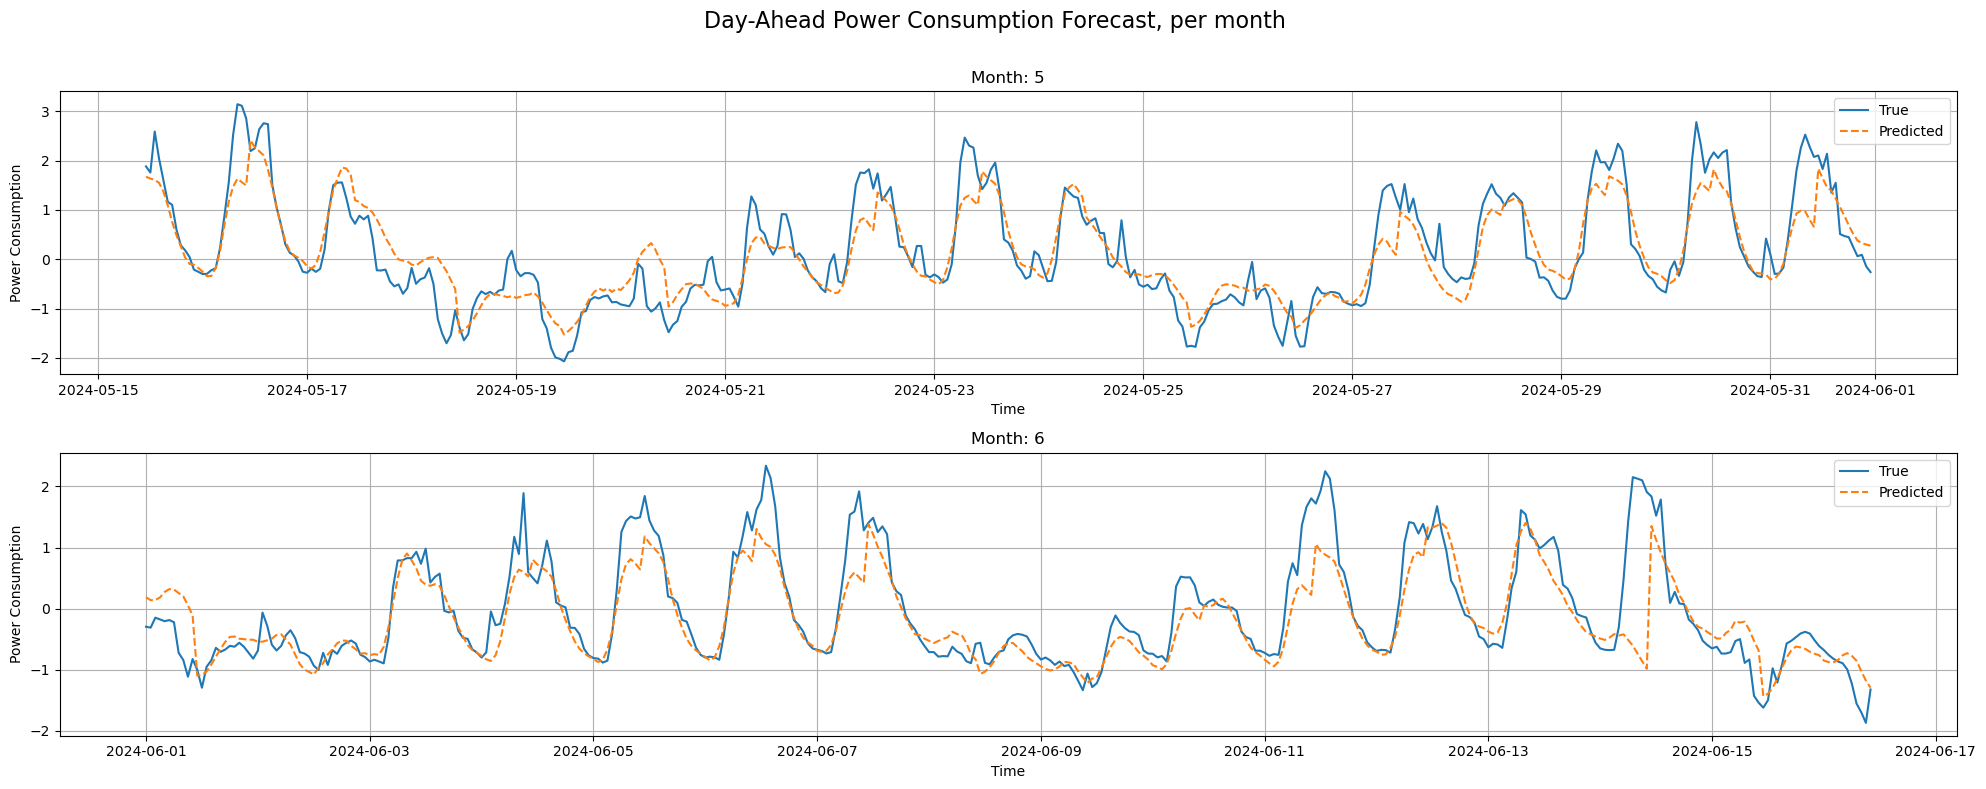

In [24]:
# Plot predicted vs true target variable
file_path = os.path.join(current_directory, 'results/LSTM.png')
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, per month", file_path)

In [25]:
# Import metrics for predictions accuracy evaluation

# MSE
from sklearn.metrics import mean_squared_error

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# MAE
from sklearn.metrics import mean_absolute_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # * 100

# ME
from sklearn.metrics import max_error

In [26]:
# Evaluate prediction accuracy
file_path = os.path.join(current_directory, 'results/errors.csv')
errors = pd.read_csv(file_path, index_col=0)

new_row = {'RMSE': root_mean_squared_error(actuals, predictions), 
                        'MAE': mean_absolute_error(actuals, predictions), 
                        'ME': max_error(actuals, predictions), 
                        'MAPE': mean_absolute_percentage_error(actuals, predictions)}

errors.loc['LSTM'] = new_row

file_path = os.path.join(current_directory, 'results/errors.csv')
errors.to_csv(file_path)

In [27]:
errors

,RMSE,MAE,ME,MAPE
LSTM,0.50068,0.33957,2.95803,1.37053


### Validation of Model Assumptions with Residuals

The purpose of Residual Analysis is to validate whether the assumptions of the model are satisfied, ensuring reliable predictions. Specifically, residuals should exhibit Gaussianity (normality) and homoscedasticity (constant variance).
**Plots for Residual Analysis**:
   - **Residuals vs. Predicted Values**:
     - **Goal**: Check for patterns in residuals that may indicate model misspecification (e.g., non-linearity or heteroscedasticity).
     - **What to look for**: Residuals should be randomly scattered around zero, without any discernible trend or structure.
   - **QQ Plot of Residuals**:
     - **Goal**: Assess whether the residuals follow a normal distribution.
     - **What to look for**: Points should fall approximately along the reference line. Deviations suggest non-normality.
   - **Histogram of Residuals**:
     - **Goal**: Visualize the distribution of residuals.
     - **What to look for**: The histogram should resemble a symmetric bell curve centered at zero.

**Insights from the Analysis**:
   - **Non-Gaussian Residuals**: Indicates that the model may not fully capture the underlying data-generating process.
   - **Heteroscedasticity (non-constant variance)**: Suggests that the variance of errors changes with predicted values, requiring potential model adjustments (e.g., transformations or different loss functions).
   - **Trends in Residuals vs. Predictions**: Suggests that the model might need additional features, better hyperparameter tuning, or a more complex architecture.

Residuals are evaluated for different hours of the day as trends in prediction accuracy and confidence intervals width are observed indicating that the model's performance may differ across specific hours.

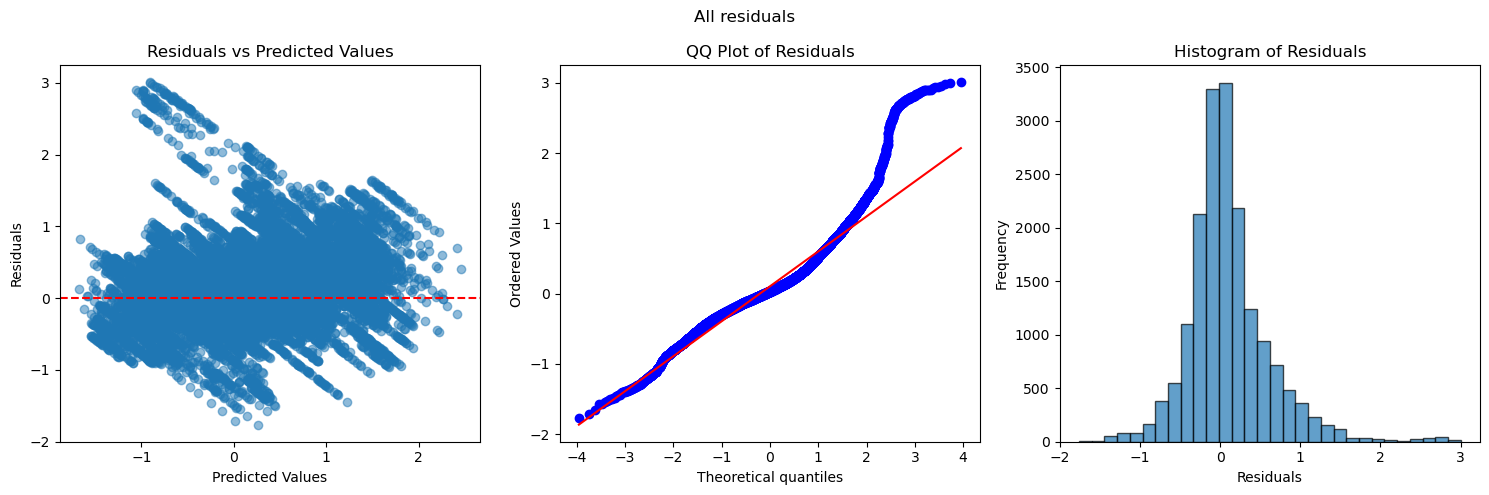

In [30]:
# All residuals
residuals_all = y_true - y_pred
file_path = os.path.join(current_directory, f'results/residuals_plot.png')
title = 'All residuals'
plot_residuals(residuals_all, y_pred, title, file_path)

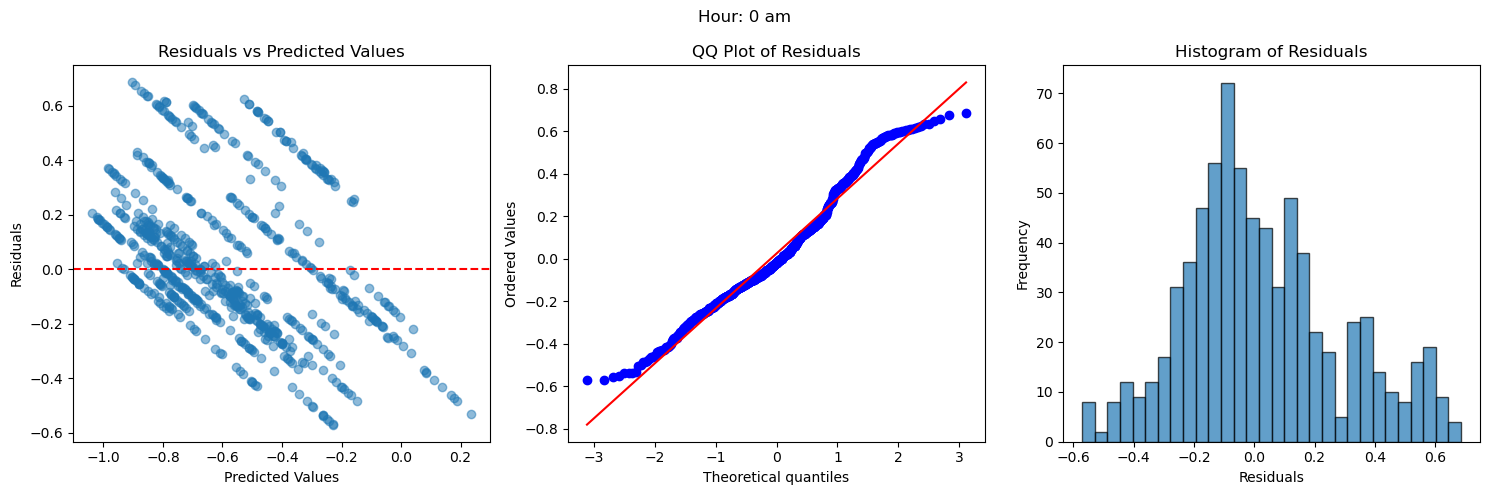

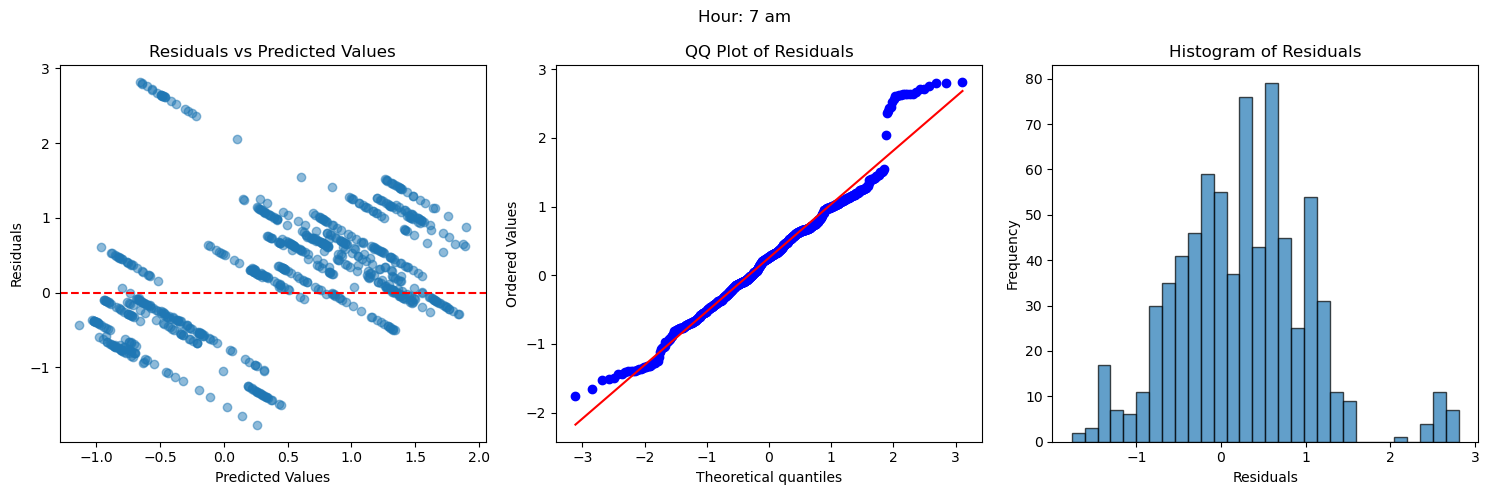

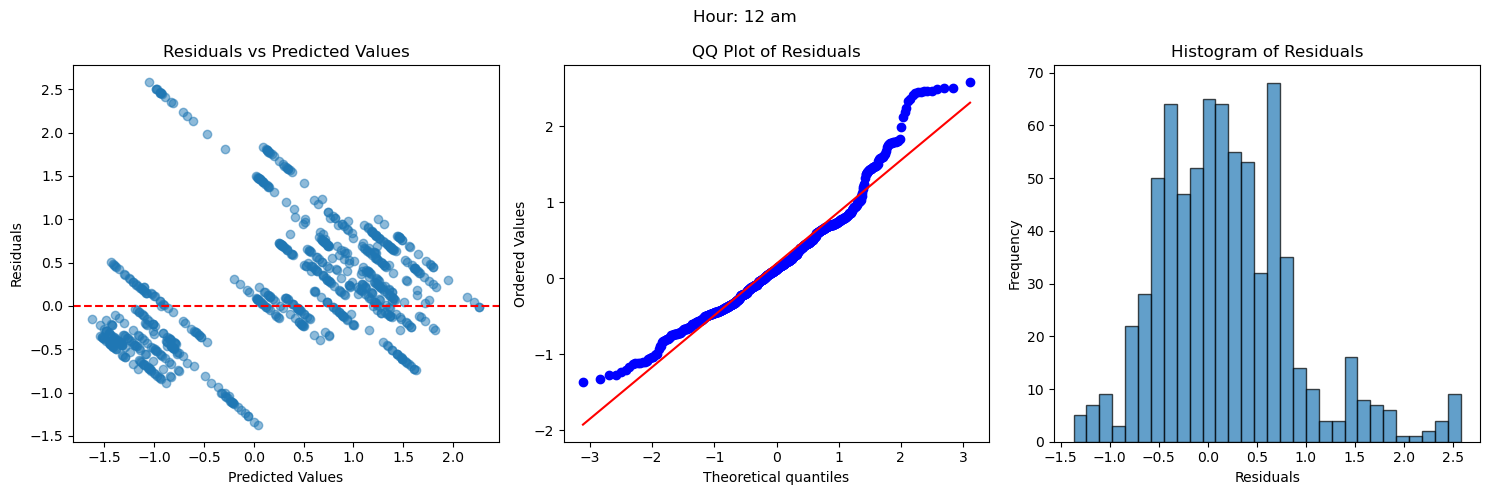

In [31]:
# Residuals at specific times of the day 
hours = [0, 7, 12]
y_true_all_filtered, y_pred_all_filtered, residuals_all_filtered = extract_all_residuals(y_true, y_pred, prediction_timestamps, hours)

for i, hour in enumerate(hours):
    hour_str = str(hour)
    file_path = os.path.join(current_directory, f'results/residuals_all_plot_LSTM_{hour_str}_am.png')
    title = f'Hour: {hour_str} am'
    plot_residuals(residuals_all_filtered.iloc[i].values, y_pred_all_filtered.iloc[i].values, title, file_path)

## Monte Carlo Dropout

MC Dropout is employed with the purpose of estimating the uncertainty in predictions. It quantifies it by sampling multiple outputs from the model under different dropout configurations. This is particularly useful when aimed at understanding model reliability.

**Working Principle**:
   - **Dropout in Evaluation**: While dropout layers are typically disabled during evaluation (`model.eval()`), MC Dropout explicitly enables dropout during testing (`model.enable_mc_dropout()`). This allows for stochastic behavior in the network even at inference time.
   - **Sampling Predictions**: 
     - The function `monte_carlo_predictions` performs `num_samples` forward passes through the model, each with different dropout-induced randomness.
     - Each forward pass generates a set of predictions, simulating predictions under different plausible models.
   - **Aggregate Predictions**:
     - **Mean Prediction**: The average of all sampled predictions provides the final output, reducing noise and accounting for uncertainty.
     - **Uncertainty**: The standard deviation across predictions is used as a measure of the model's uncertainty, giving insights into confidence.

**Outcome**:
   - **Test Loss**: The mean predictions are compared against the true labels (`y_test_tensor`) using MSE to compute the overall performance.
   - **Confidence Intervals**: The uncertainty values provide insights into how confident the model is for each prediction.

In [34]:
def monte_carlo_predictions(model, X, num_samples=100):
    """
    Perform Monte Carlo Dropout predictions.

    Parameters:
        model (nn.Module): TCN model with MC Dropout enabled.
        X (torch.Tensor): Input tensor of shape (batch_size, seq_length, num_features).
        num_samples (int): Number of MC samples.

    Returns:
        torch.Tensor: Mean predictions.
        torch.Tensor: Prediction standard deviations (uncertainty).
    """
    model.enable_mc_dropout()  # Enable dropout during testing
    predictions = []

    for _ in range(num_samples):
        with torch.no_grad():
            predictions.append(model(X))  # Append prediction for each MC sample

    predictions = torch.stack(predictions)  # Shape: (num_samples, batch_size, output_size)
    mean_prediction = predictions.mean(dim=0)  # Mean over MC samples
    uncertainty = predictions.std(dim=0)  # Std dev over MC samples

    return mean_prediction, uncertainty

In [35]:
# Load the saved model and data
checkpoint = torch.load("best_lstm_model_and_data.pth")

# Recreate the model
model = LSTMModel(
    checkpoint['input_size'],
    checkpoint['hidden_size'],
    checkpoint['output_size'],
    checkpoint['num_layers'],
    checkpoint['dropout_rate']).to(device)

# Ensure tensors are on the correct device
X_test_tensor = checkpoint['X_test_tensor'].to(device)
y_test_tensor = checkpoint['y_test_tensor'].to(device)

# Load the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

# Enable MC Dropout during evaluation
model.enable_mc_dropout()  # Enable dropout layers specifically

# Use MC Dropout for predictions
num_samples = 100  # Number of Monte Carlo samples
mean_predictions, uncertainties = monte_carlo_predictions(model, X_test_tensor, num_samples)

# Compute test loss using the mean predictions
criterion = nn.MSELoss()
test_loss = criterion(mean_predictions, y_test_tensor).item()
print(f"Test Loss (MC Dropout): {test_loss:.4f}")

# Convert results to numpy for further analysis
mean_predictions_np = mean_predictions.cpu().numpy()
uncertainties_np = uncertainties.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

Test Loss (MC Dropout): 0.2814


In [36]:
# Save mean and standard deviation of predicted variable and true target variable
mean_predictions = day_ahead_forecast(mean_predictions_np, prediction_timestamps)
uncertainties = day_ahead_forecast(uncertainties_np, prediction_timestamps)
actuals = day_ahead_forecast(y_true, prediction_timestamps)

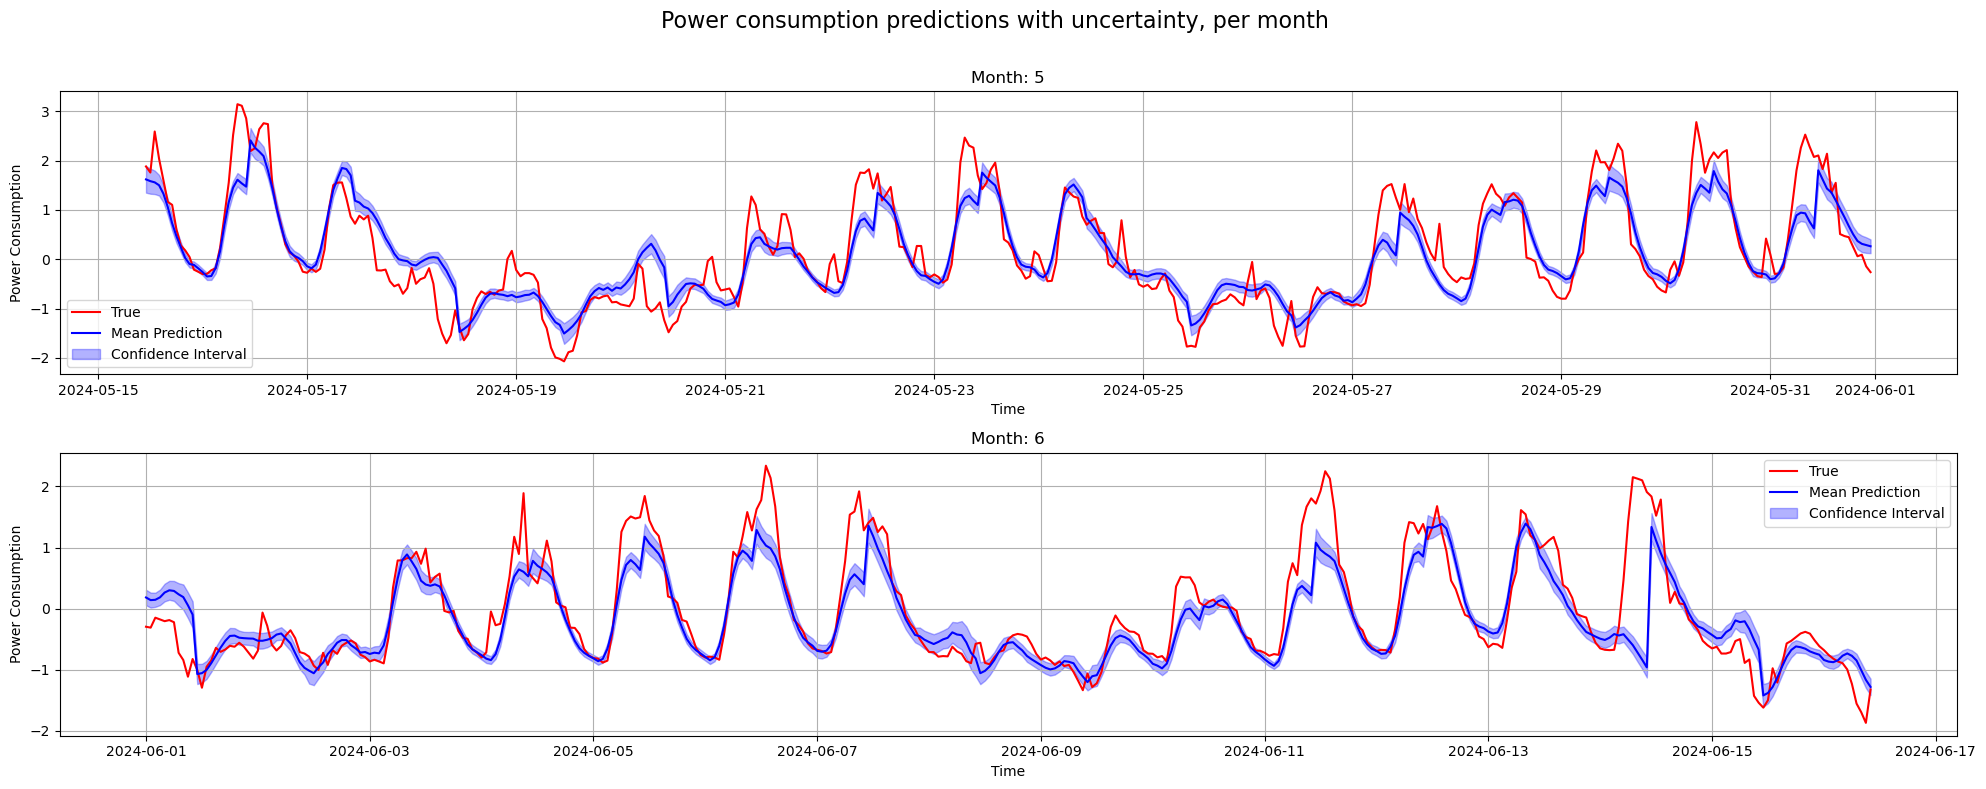

In [37]:
# Plot mean and confidence interval of predicted target variable vs true target variable
file_path = os.path.join(current_directory, 'results/LSTM_MCDropOut.png')
confidence_level = 1.96
plot_results_with_uncertainty_by_month(mean_predictions, uncertainties, confidence_level, actuals, 'Power consumption predictions with uncertainty, per month', file_path)

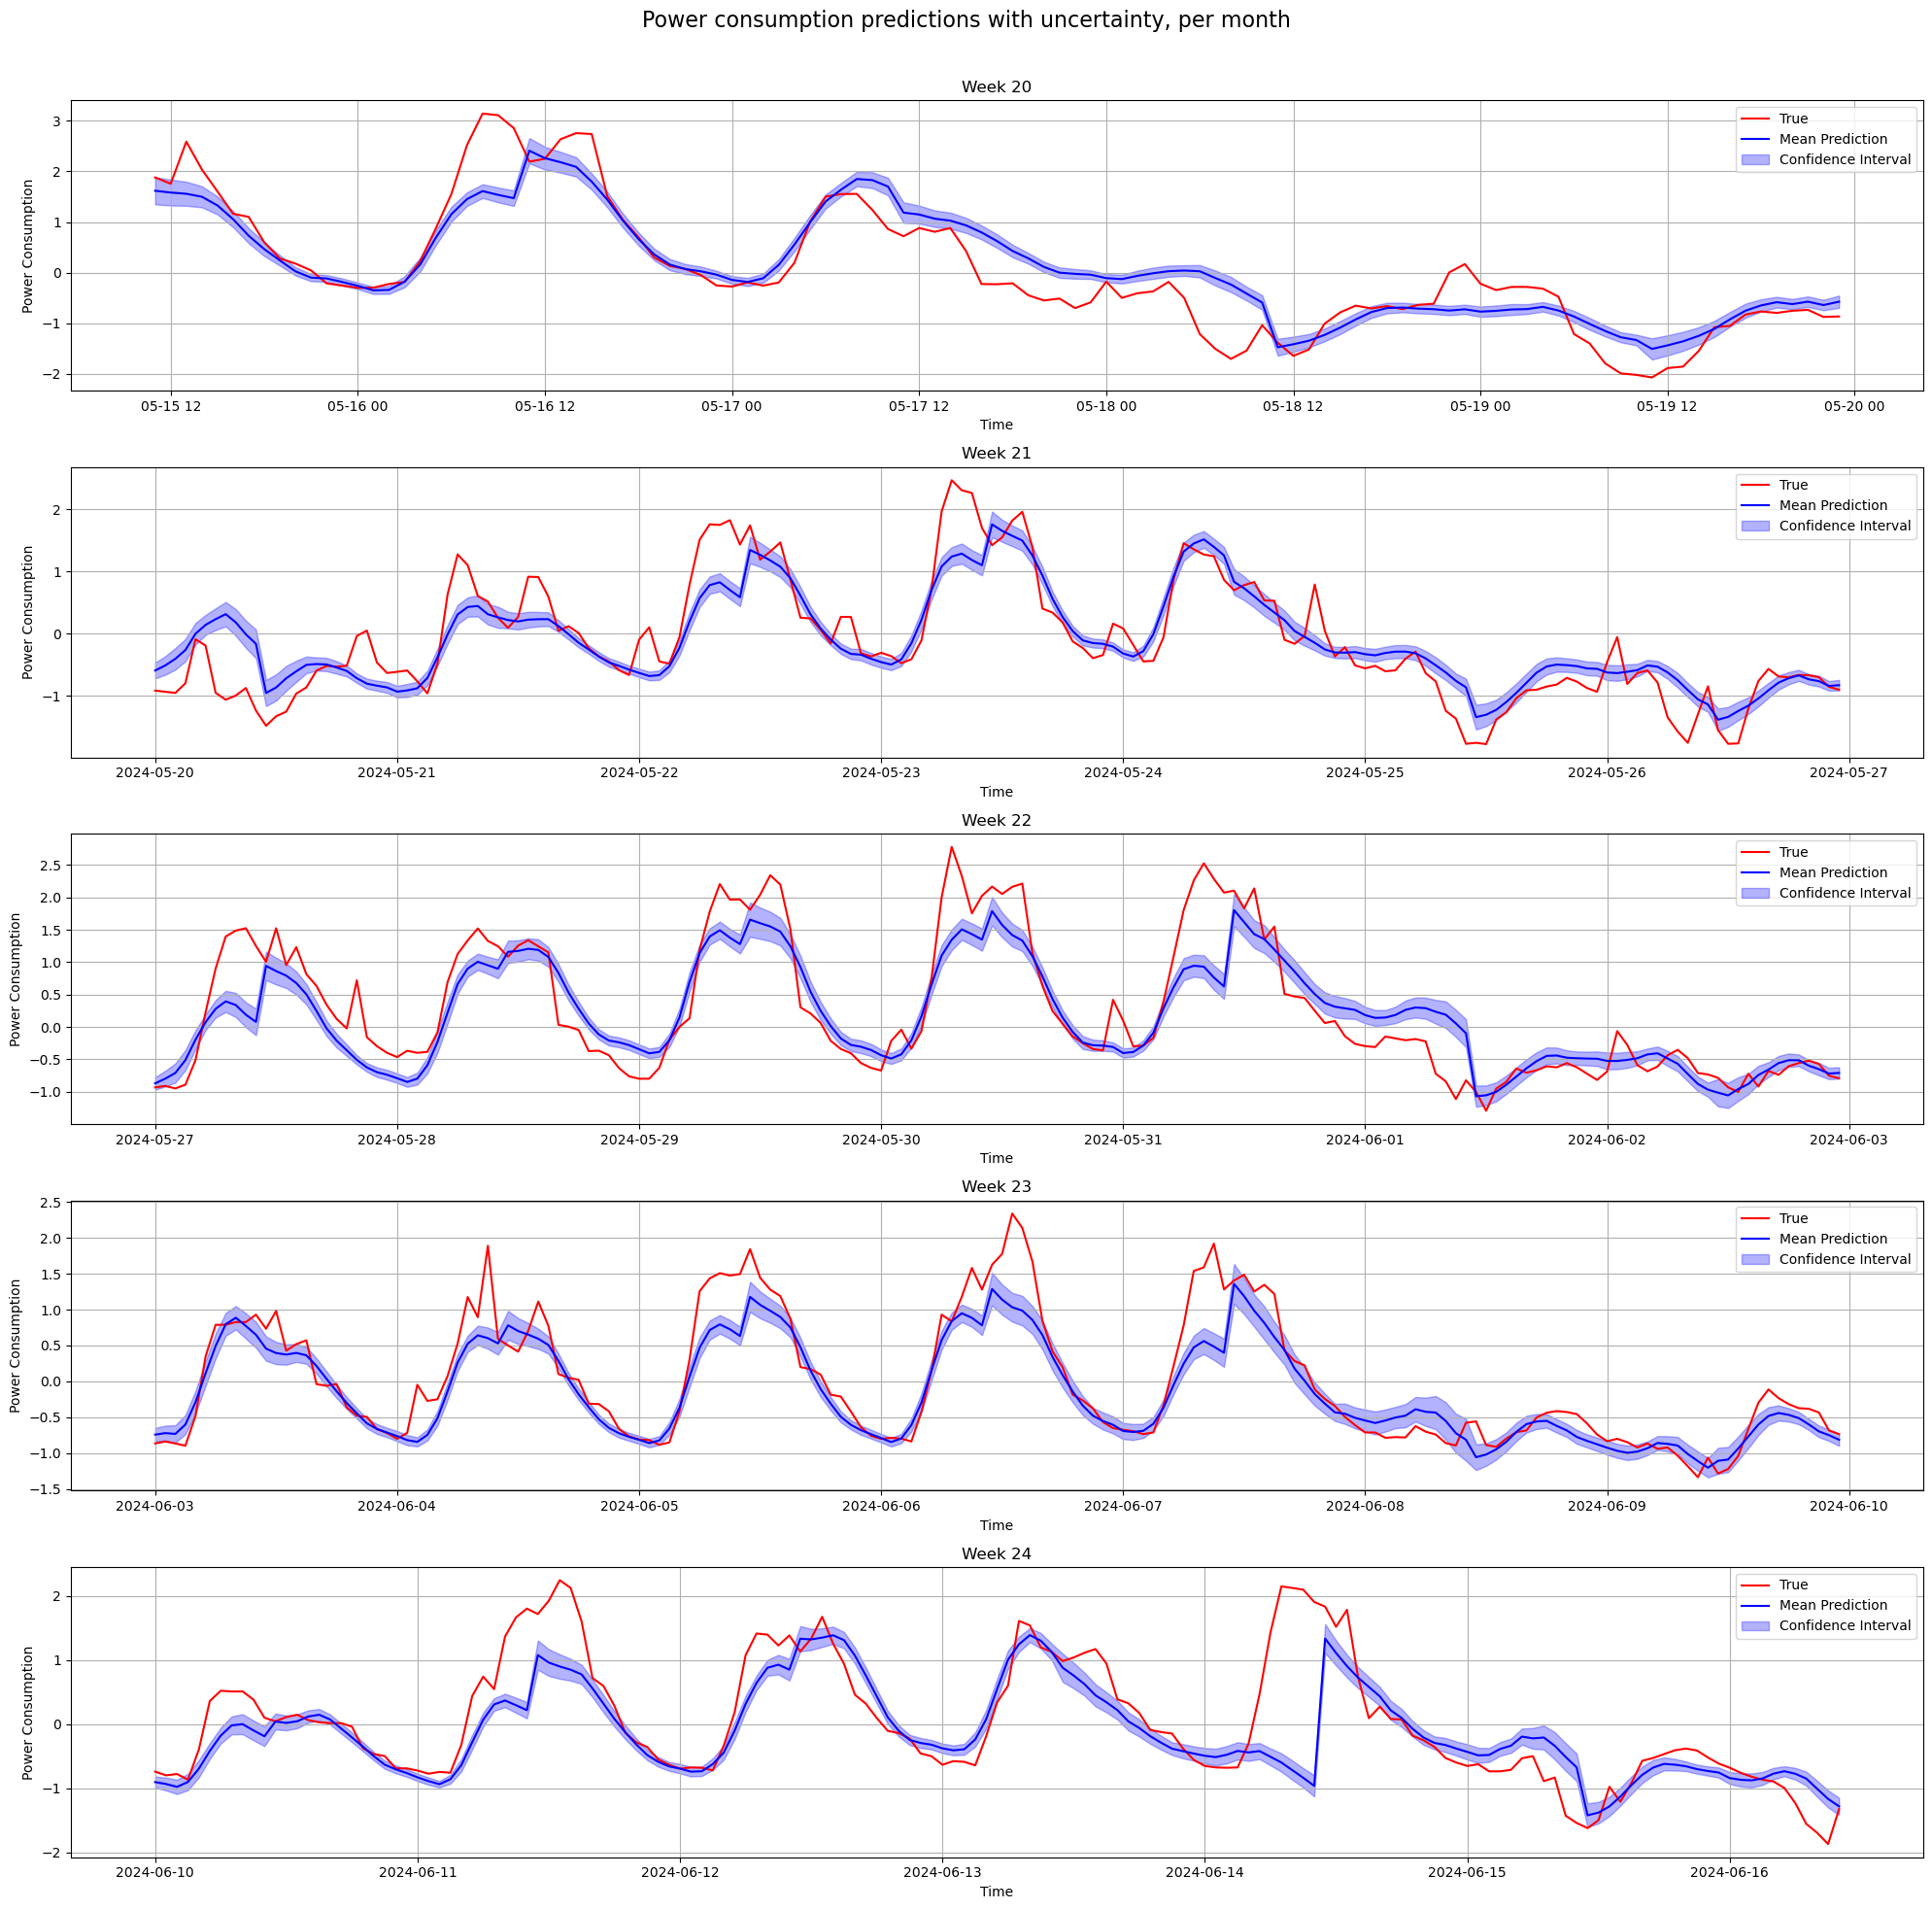

In [38]:
# Plot by week
file_path = os.path.join(current_directory, 'results/LSTM_MCDropOut_by_week.png')
plot_results_with_uncertainty_by_week(mean_predictions, uncertainties, confidence_level, actuals, 'Power consumption predictions with uncertainty, per month', file_path)

### Uncertainty of predictions

The predictions uncertainty is quantified with the metrics PICP and PINAW. 

1. **Prediction Interval Coverage Probability (PICP)**:
   - Measures the percentage of true values captured within the prediction intervals.
   - A high PICP (e.g., 95%) indicates well-calibrated intervals.
   - Too low: Intervals miss actual values (underestimating uncertainty).
   - Too high: Intervals are overly wide (too conservative).

2. **Prediction Interval Normalized Average Width (PINAW)**:
   - Quantifies the average width of prediction intervals relative to the range of true values.
   - A low PINAW means the intervals are narrow (sharp).
   - Too narrow: Risk of poor coverage (low PICP).
   - Too wide: Excessive conservatism, reducing utility.

The goal is to balance **PICP** (coverage) and **PINAW** (sharpness) to create reliable and efficient prediction intervals.

In [40]:
file_path = os.path.join(current_directory, 'results/uncertainty_evaluation.csv')
uncertainty_evaluation = pd.read_csv(file_path, index_col=0)
new_row = {'PICP': picp(actuals, mean_predictions - confidence_level * uncertainties, mean_predictions + confidence_level * uncertainties), 
                        'PINAW': pinaw(actuals, mean_predictions - confidence_level * uncertainties, mean_predictions + confidence_level * uncertainties)}

uncertainty_evaluation.loc['LSTM'] = new_row
file_path = os.path.join(current_directory, 'results/uncertainty_evaluation.csv')
uncertainty_evaluation.to_csv(file_path) 

uncertainty_evaluation

,PICP,PINAW
LSTM,0.30729,0.05013


## Include Forecast of temperature

Now **forecasted features** are integrated into the feature matrix to enhance prediction accuracy for the target variable, such as power consumption. Here's the working principle:

1. **Historical Features**:
   - A **sliding window approach** extracts historical data (e.g., past 7 days) for both the target variable and other exogenous variables like temperature.

2. **Forecasted Features**:
   - If forecasts are available for some variables (e.g., temperature for the next 24 hours), these are aligned with the corresponding future time steps.
   - These forecasts are added to the feature matrix, providing future context for the model to learn from.

In this way, each sample in the matrix includes both **historical data** (windowed) and **forecasted features** for the prediction horizon, combining past trends with future forecasts. This approach allows the model to leverage both past behavior and expected future conditions, improving its ability to predict the target variable for the given forecast horizon.

In [43]:
file_path = os.path.join(current_directory, 'data_augmented/X_train_include_forecast.npy')
X_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/X_test_include_forecast.npy')
X_test = np.load(file_path)

In [44]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [45]:
### LSTM Training
# Initialize the LSTM Model
input_size = X_train.shape[2]  # Number of features per time step

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)

learning_rate = 1e-3
weight_decay = 1e-4  # L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

# Early stopping parameters
patience_limit = 5
best_val_loss = float("inf")
patience_counter = 0

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Training loop with early stopping
num_epochs = 50  # Increased epochs to allow for early stopping
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Compute average training loss for the epoch
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)  # Save training loss

    end_time = time.time()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f} seconds")

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor.to(device))
        val_loss = criterion(val_predictions, y_test_tensor.to(device)).item()
        val_losses.append(val_loss)  # Save validation loss

    print(f"Validation Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'hidden_size': hidden_size,
            'output_size': output_size,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate,
            'X_train_tensor': X_train_tensor.cpu(),
            'X_test_tensor': X_test_tensor.cpu(),
            'y_train_tensor': y_train_tensor.cpu(),
            'y_test_tensor': y_test_tensor.cpu(),
            'batch_size': batch_size,
        }, "best_lstm_model_and_data_include_forecast.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break

Epoch 1, Loss: 0.3545, Time: 31.09 seconds
Validation Loss: 0.4872
Epoch 2, Loss: 0.2135, Time: 30.60 seconds
Validation Loss: 0.4565
Epoch 3, Loss: 0.1792, Time: 29.25 seconds
Validation Loss: 0.3932
Epoch 4, Loss: 0.1524, Time: 29.98 seconds
Validation Loss: 0.3569
Epoch 5, Loss: 0.1274, Time: 31.60 seconds
Validation Loss: 0.3900
Epoch 6, Loss: 0.1144, Time: 31.84 seconds
Validation Loss: 0.3243
Epoch 7, Loss: 0.1037, Time: 30.30 seconds
Validation Loss: 0.3908
Epoch 8, Loss: 0.0987, Time: 31.56 seconds
Validation Loss: 0.3930
Epoch 9, Loss: 0.0986, Time: 30.68 seconds
Validation Loss: 0.3826
Epoch 10, Loss: 0.0806, Time: 31.76 seconds
Validation Loss: 0.3910
Epoch 11, Loss: 0.0747, Time: 31.32 seconds
Validation Loss: 0.4210
Early stopping triggered.


In [46]:
# Test the model
checkpoint = torch.load("best_lstm_model_and_data_include_forecast.pth")
model.load_state_dict(checkpoint['model_state_dict'])  # Load the best model
model.eval()

# Evaluate on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor.to(device))
    test_loss = criterion(test_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.3243


In [47]:
y_pred = test_predictions.cpu().detach().numpy()  # Predictions, size: (num_test_samples, forecast_horizon)
y_true = y_test_tensor.cpu().numpy()  # Ground truth, size: (num_test_samples, forecast_horizon)

In [48]:
predictions = day_ahead_forecast(y_pred, prediction_timestamps)
actuals = day_ahead_forecast(y_true, prediction_timestamps)

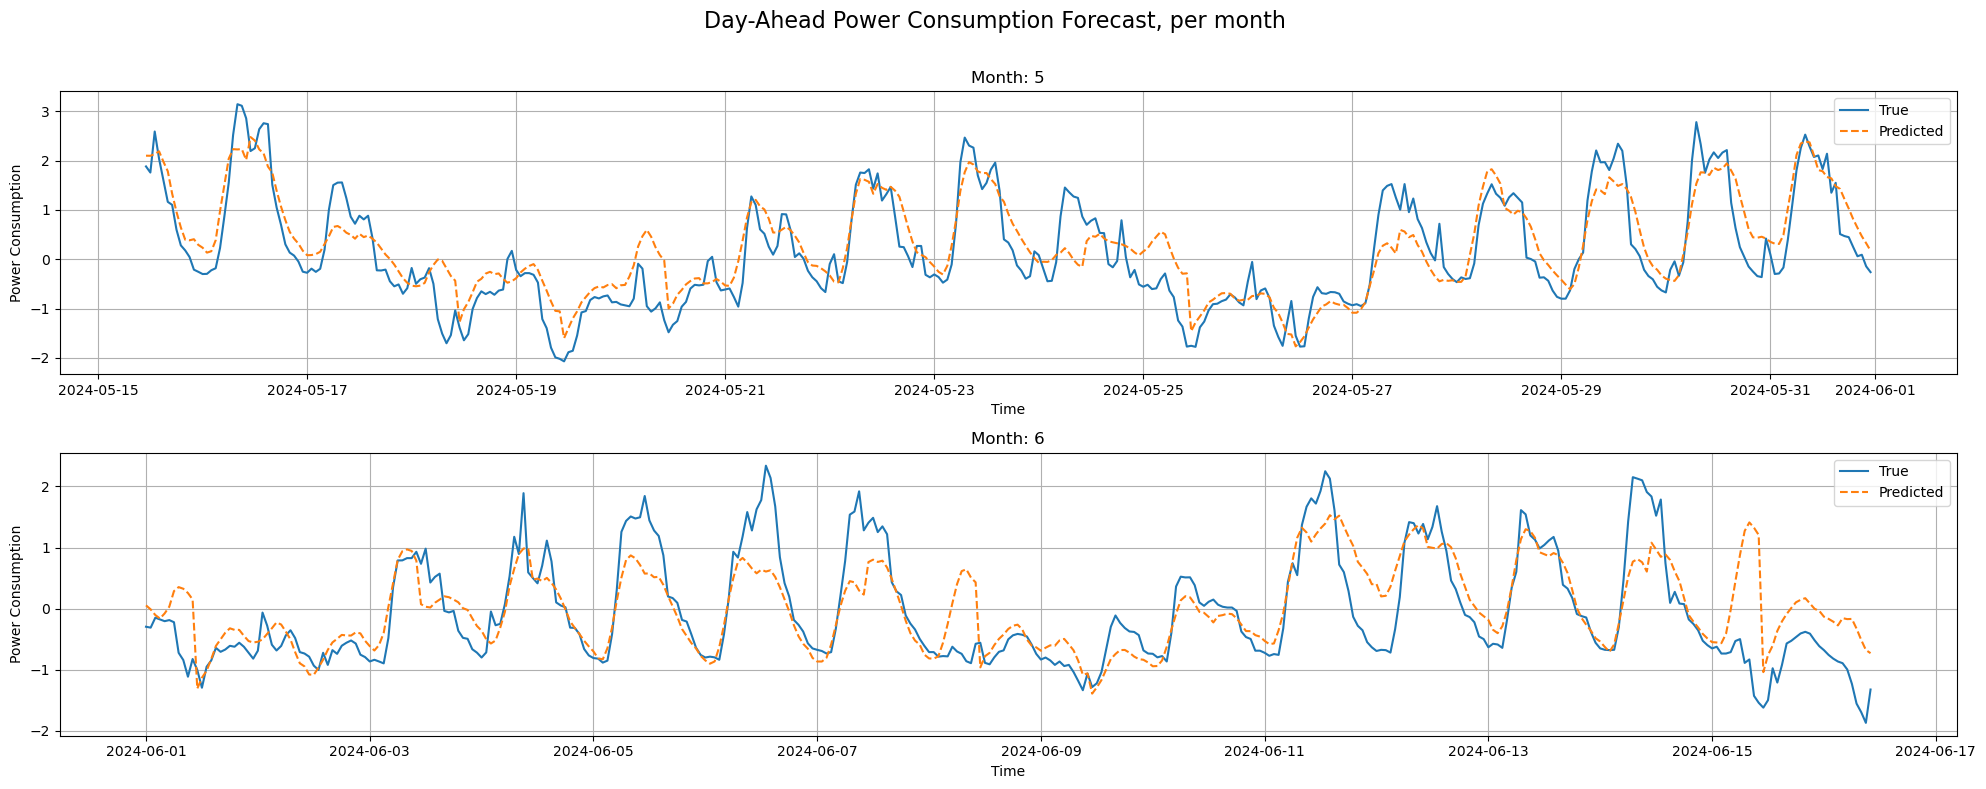

In [49]:
file_path = os.path.join(current_directory, 'results/LSTM_include_forecast.png')
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, per month", file_path)

In [50]:
file_path = os.path.join(current_directory, 'results/errors.csv')
errors = pd.read_csv(file_path, index_col=0)

In [51]:
new_row = {'RMSE': root_mean_squared_error(actuals, predictions), 
                        'MAE': mean_absolute_error(actuals, predictions), 
                        'ME': max_error(actuals, predictions), 
                        'MAPE': mean_absolute_percentage_error(actuals, predictions)}

errors.loc['LSTM - include forecast'] = new_row

In [52]:
errors

,RMSE,MAE,ME,MAPE
LSTM,0.50068,0.33957,2.95803,1.37053
LSTM - include forecast,0.55726,0.41862,2.74991,1.63643


In [53]:
file_path = os.path.join(current_directory, 'results/errors.csv')
errors.to_csv(file_path)